In [1]:
import numpy as np
import pandas as pd
import string as st
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import spacy
import contractions
import sklearn
import plotly.graph_objects as go
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV 
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score,roc_curve,auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

LOAD DATASET

In [2]:
raw = pd.read_csv('tripadvisor_hotel_reviews.csv')
raw.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [3]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [4]:
raw['Rating'].value_counts()

Rating
5    9054
4    6039
3    2184
2    1793
1    1421
Name: count, dtype: int64

DATA PREPROCESS - STAGE 1

In [5]:
data_pre1 = raw.copy()

In [6]:
positive = [4, 5]
neutral = [3]
negative = [1, 2]

def sentiment_check(rating):
    if rating in positive:
        return 1
    elif rating in negative:
        return -1
    else:
        return 0

In [7]:
data_pre1['Sentiment'] = data_pre1['Rating'].apply(sentiment_check)

In [8]:
data_pre1.head()

,Review,Rating,Sentiment
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,-1
2,nice rooms not 4* experience hotel monaco seat...,3,0
3,"unique, great stay, wonderful time hotel monac...",5,1
4,"great stay great stay, went seahawk game aweso...",5,1


SPLITTING TRAIN AND TEST

In [9]:
data_pre1['Rating'] = data_pre1['Rating'].astype(str)
data_pre1_r1 = data_pre1[data_pre1['Rating'].isin(['1'])]
data_pre1_r2 = data_pre1[data_pre1['Rating'].isin(['2'])]
data_pre1_r3 = data_pre1[data_pre1['Rating'].isin(['3'])]
data_pre1_r4 = data_pre1[data_pre1['Rating'].isin(['4'])]
data_pre1_r5 = data_pre1[data_pre1['Rating'].isin(['5'])]

In [10]:
rt1_train = data_pre1_r1.sample(n=1000, random_state=0)
rt2_train = data_pre1_r2.sample(n=1000, random_state=0)
rt3_train = data_pre1_r3.sample(n=2000, random_state=0)
rt4_train = data_pre1_r4.sample(n=1000, random_state=0)
rt5_train = data_pre1_r5.sample(n=1000, random_state=0)
# rt1_train = data_pre1_r1.sample(n=1050, random_state=0)
# rt2_train = data_pre1_r2.sample(n=1275, random_state=0)
# rt3_train = data_pre1_r3.sample(n=1575, random_state=0)
# rt4_train = data_pre1_r4.sample(n=4500, random_state=0)
# rt5_train = data_pre1_r5.sample(n=6750, random_state=0)

train_combine = [rt1_train, rt2_train, rt3_train, rt4_train, rt5_train]
training_set = pd.concat(train_combine)

test_set = data_pre1[~data_pre1['Review'].isin(training_set['Review'])]

training_set = training_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

In [11]:
training_set['Rating'].value_counts()

Rating
3    2000
1    1000
2    1000
4    1000
5    1000
Name: count, dtype: int64

In [12]:
test_set['Rating'].value_counts()

Rating
5    8054
4    5039
2     793
1     421
3     184
Name: count, dtype: int64

In [13]:
training_set = training_set.drop(['Rating'], axis=1)
training_set.to_csv('train.csv', index=False)
test_set = test_set.drop(['Rating'], axis=1)
test_set.to_csv('test.csv', index=False)

DATA PREPROCESSING - MAIN

In [14]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [15]:
train.head(10)

,Review,Sentiment
0,dissapointing hotel punta cana general dreams ...,-1
1,horrible ritz certainly not 5-star hotel nor l...,-1
2,"no service smile just got disappointment, food...",-1
3,"scared stayed wife hotel really disgusted, fle...",-1
4,not worth price date stay november 16-19 2008m...,-1
5,dirty overpriced hotel just returned 4 nite st...,-1
6,"save money hostel, booked night stay january s...",-1
7,"not family friendly hotel, travelled wife 2 yr...",-1
8,"respectable mommy kicked hyatt, letter sent hy...",-1
9,simply.terrible look lobby hotel think just ar...,-1


EXPAND CONTRACTIONS

In [16]:
train2 = train.copy()
train2['Review'] = train2['Review'].apply(lambda x: [contractions.fix(word) for word in x.split()])
train2['Review'] = [' '.join(map(str, l)) for l in train2['Review']]
train2.head(10)

,Review,Sentiment
0,dissapointing hotel punta cana general dreams ...,-1
1,horrible ritz certainly not 5-star hotel nor l...,-1
2,"no service smile just got disappointment, food...",-1
3,"scared stayed wife hotel really disgusted, fle...",-1
4,not worth price date stay november 16-19 2008m...,-1
5,dirty overpriced hotel just returned 4 nite st...,-1
6,"save money hostel, booked night stay january s...",-1
7,"not family friendly hotel, travelled wife 2 yr...",-1
8,"respectable mommy kicked hyatt, letter sent hy...",-1
9,simply.terrible look lobby hotel think just ar...,-1


CASE FOLDING (LOWERCASING)

In [17]:
train3 = train2.copy()
train3["Review"] = train3["Review"].str.lower()
train3.head(10)

,Review,Sentiment
0,dissapointing hotel punta cana general dreams ...,-1
1,horrible ritz certainly not 5-star hotel nor l...,-1
2,"no service smile just got disappointment, food...",-1
3,"scared stayed wife hotel really disgusted, fle...",-1
4,not worth price date stay november 16-19 2008m...,-1
5,dirty overpriced hotel just returned 4 nite st...,-1
6,"save money hostel, booked night stay january s...",-1
7,"not family friendly hotel, travelled wife 2 yr...",-1
8,"respectable mommy kicked hyatt, letter sent hy...",-1
9,simply.terrible look lobby hotel think just ar...,-1


NUMBER REMOVAL

In [18]:
train4 = train3.copy()
train4['Review'] = train4['Review'].apply(lambda x: re.sub("[0-9]", " ", x))
train4.head(10)

,Review,Sentiment
0,dissapointing hotel punta cana general dreams ...,-1
1,horrible ritz certainly not -star hotel nor l...,-1
2,"no service smile just got disappointment, food...",-1
3,"scared stayed wife hotel really disgusted, fle...",-1
4,not worth price date stay november - m...,-1
5,dirty overpriced hotel just returned nite st...,-1
6,"save money hostel, booked night stay january s...",-1
7,"not family friendly hotel, travelled wife yr...",-1
8,"respectable mommy kicked hyatt, letter sent hy...",-1
9,simply.terrible look lobby hotel think just ar...,-1


PUNCTUATION REMOVAL

In [19]:
train5 = train4.copy()
train5['Review'] = train5['Review'].apply(lambda x: re.sub('[%s]' % re.escape(st.punctuation), '' , x))
train5.head(10)

,Review,Sentiment
0,dissapointing hotel punta cana general dreams ...,-1
1,horrible ritz certainly not star hotel nor le...,-1
2,no service smile just got disappointment food ...,-1
3,scared stayed wife hotel really disgusted flea...,-1
4,not worth price date stay november my...,-1
5,dirty overpriced hotel just returned nite st...,-1
6,save money hostel booked night stay january st...,-1
7,not family friendly hotel travelled wife yr ...,-1
8,respectable mommy kicked hyatt letter sent hya...,-1
9,simplyterrible look lobby hotel think just art...,-1


STOPWORDS REMOVAL

In [20]:
nltk.download('stopwords')
", ".join(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jychpr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [21]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
        return " ".join([word for word in str(text).split() if word not in STOPWORDS])

In [22]:
train6 = train5.copy()
train6['Review'] = train6['Review'].apply(lambda text: remove_stopwords(text))
train6.head(10)

,Review,Sentiment
0,dissapointing hotel punta cana general dreams ...,-1
1,horrible ritz certainly star hotel leading hot...,-1
2,service smile got disappointment food selectio...,-1
3,scared stayed wife hotel really disgusted flea...,-1
4,worth price date stay november family arrived ...,-1
5,dirty overpriced hotel returned nite stay extr...,-1
6,save money hostel booked night stay january st...,-1
7,family friendly hotel travelled wife yr old bo...,-1
8,respectable mommy kicked hyatt letter sent hya...,-1
9,simplyterrible look lobby hotel think art deco...,-1


LEMMATIZATION

In [23]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

[nltk_data] Downloading package wordnet to /home/jychpr/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
train7 = train6.copy()
train7['Review'] = train7['Review'].apply(lambda text: lemmatize_words(text))
train7.head(10)

,Review,Sentiment
0,dissapointing hotel punta cana general dream o...,-1
1,horrible ritz certainly star hotel leading hot...,-1
2,service smile got disappointment food selectio...,-1
3,scared stayed wife hotel really disgusted flea...,-1
4,worth price date stay november family arrived ...,-1
5,dirty overpriced hotel returned nite stay extr...,-1
6,save money hostel booked night stay january st...,-1
7,family friendly hotel travelled wife yr old bo...,-1
8,respectable mommy kicked hyatt letter sent hya...,-1
9,simplyterrible look lobby hotel think art deco...,-1


PROCESSING

In [25]:
train_proc = train7.copy()
train_proc.head(10)

,Review,Sentiment
0,dissapointing hotel punta cana general dream o...,-1
1,horrible ritz certainly star hotel leading hot...,-1
2,service smile got disappointment food selectio...,-1
3,scared stayed wife hotel really disgusted flea...,-1
4,worth price date stay november family arrived ...,-1
5,dirty overpriced hotel returned nite stay extr...,-1
6,save money hostel booked night stay january st...,-1
7,family friendly hotel travelled wife yr old bo...,-1
8,respectable mommy kicked hyatt letter sent hya...,-1
9,simplyterrible look lobby hotel think art deco...,-1


In [26]:
train_proc.count()

Review       6000
Sentiment    6000
dtype: int64

TF-IDF

In [27]:
docs = list(train_proc['Review'])
tfidf_vectorizer=TfidfVectorizer(max_features=20000)
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(docs)

In [28]:
X = tfidf_vectorizer_vectors.toarray()
Y = train_proc['Sentiment']

In [29]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
Y

0      -1
1      -1
2      -1
3      -1
4      -1
       ..
5995    1
5996    1
5997    1
5998    1
5999    1
Name: Sentiment, Length: 6000, dtype: int64

In [31]:
len(X)

6000

In [32]:
len(X[0])

20000

TRAIN TEST SPLIT

In [33]:
X_train,X_test,y_train,y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [34]:
len(X_train)

4800

In [35]:
len(X_test)

1200

CLASSIFICATION

In [36]:
RANDOM_SEED=0

In [37]:
lr = LogisticRegression(random_state=RANDOM_SEED).fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print("Training Accuracy score: "+str(round(accuracy_score(y_train,lr.predict(X_train)),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,lr.predict(X_test)),4)))

Training Accuracy score: 0.9046
Testing Accuracy score: 0.7217


In [38]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.76      0.81      0.78       385
     neutral       0.60      0.62      0.61       393
    negative       0.80      0.74      0.77       422

    accuracy                           0.72      1200
   macro avg       0.72      0.72      0.72      1200
weighted avg       0.72      0.72      0.72      1200



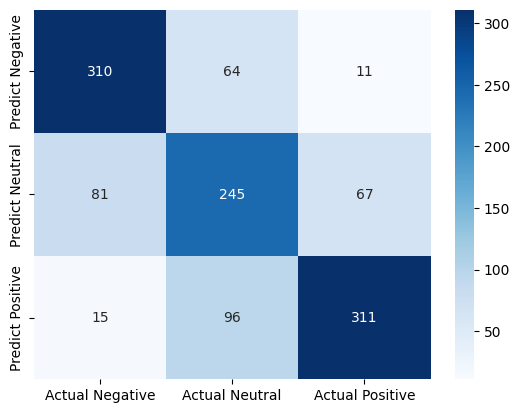

In [39]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

TEST ON REST OF DATA

In [40]:
len(test)

14491

In [41]:
docs_test_rest = list(test['Review'])
tfidf_vectorizer=TfidfVectorizer(max_features=20000)
tfidf_vectorizer_vectors_rest=tfidf_vectorizer.fit_transform(docs_test_rest)

In [42]:
X_rest = tfidf_vectorizer_vectors_rest.toarray()
Y_rest = test['Sentiment']

In [43]:
y_pred_rest_test = lr.predict(X_rest)

In [44]:
print("Testing Accuracy score: "+str(round(accuracy_score(Y_rest,lr.predict(X_rest)),4)))

Testing Accuracy score: 0.0878


In [45]:
print(classification_report(Y_rest, y_pred_rest_test, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.08      0.99      0.15      1214
     neutral       0.04      0.01      0.01       184
    negative       0.92      0.01      0.01     13093

    accuracy                           0.09     14491
   macro avg       0.35      0.33      0.06     14491
weighted avg       0.84      0.09      0.02     14491



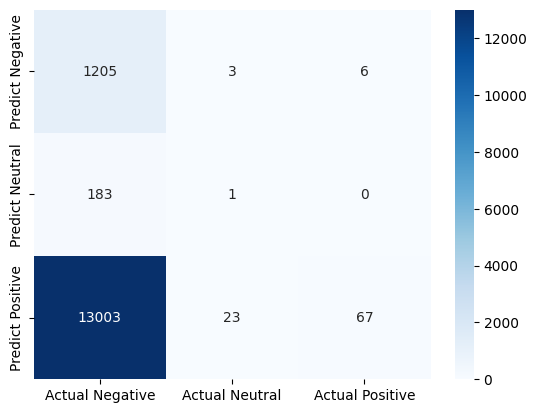

In [46]:
cm = confusion_matrix(Y_rest, y_pred_rest_test)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

REST DATA PROCESSED

In [47]:
test_proc = test.copy()
test_proc['Review'] = test_proc['Review'].apply(lambda x: [contractions.fix(word) for word in x.split()])
test_proc['Review'] = [' '.join(map(str, l)) for l in test_proc['Review']]
test_proc["Review"] = test_proc["Review"].str.lower()
test_proc['Review'] = test_proc['Review'].apply(lambda x: re.sub("[0-9]", " ", x))
test_proc['Review'] = test_proc['Review'].apply(lambda x: re.sub('[%s]' % re.escape(st.punctuation), '' , x))
test_proc['Review'] = test_proc['Review'].apply(lambda text: remove_stopwords(text))
test_proc['Review'] = test_proc['Review'].apply(lambda text: lemmatize_words(text))
test_proc.head(10)

,Review,Sentiment
0,nice hotel expensive parking got good deal sta...,1
1,ok nothing special charge diamond member hilto...,-1
2,unique great stay wonderful time hotel monaco ...,1
3,great stay great stay went seahawk game awesom...,1
4,love monaco staff husband stayed hotel crazy w...,1
5,cozy stay rainy city husband spent night monac...,1
6,hotel stayed hotel monaco cruise room generous...,1
7,excellent stayed hotel monaco past delight rec...,1
8,nice value seattle stayed night late looked co...,1
9,nice hotel good location hotel kimpton design ...,1


In [48]:
docs_test_rest_proc = list(test_proc['Review'])
tfidf_vectorizer=TfidfVectorizer(max_features=20000)
tfidf_vectorizer_vectors_rest_proc=tfidf_vectorizer.fit_transform(docs_test_rest_proc)

In [49]:
X_rest_proc = tfidf_vectorizer_vectors_rest_proc.toarray()
Y_rest_proc = test_proc['Sentiment']

In [50]:
y_pred_rest_test_proc = lr.predict(X_rest_proc)

In [51]:
print("Testing Accuracy score: "+str(round(accuracy_score(Y_rest_proc,lr.predict(X_rest_proc)),4)))

Testing Accuracy score: 0.0943


In [52]:
print(classification_report(Y_rest_proc, y_pred_rest_test_proc, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.08      0.97      0.15      1214
     neutral       0.06      0.02      0.03       184
    negative       0.84      0.01      0.03     13093

    accuracy                           0.09     14491
   macro avg       0.33      0.33      0.07     14491
weighted avg       0.77      0.09      0.04     14491



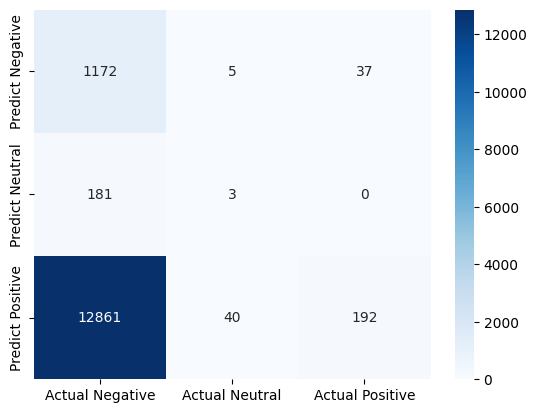

In [53]:
cm = confusion_matrix(Y_rest_proc, y_pred_rest_test_proc)
#print('Confusion matrix\n', cm)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                        index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()